In [1]:
# Libraries use 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import geopandas as gpd
from pyproj import CRS
from helper import create_dummy_df

%matplotlib inline

In [2]:
# Read dataset
df_listings = pd.read_csv('../NYC/data/listings.csv', low_memory=False, verbose=1)

# Create dataframe
df_listings = pd.DataFrame(df_listings, columns=['id', 'host_is_superhost', 'latitude', 'longitude',
                                                 'neighbourhood','neighbourhood_group_cleansed',
                                                 'property_type', 'room_type', 
                                                 'accommodates', 'bathrooms' , 'bedrooms', 'beds',
                                                 'price', 'security_deposit', 'cleaning_fee',
                                                 'guests_included', 'availability_365','number_of_reviews'
                                              ])

df_listings = df_listings.rename(columns={'neighbourhood_group_cleansed':'neighbourhood_group',
                                         'id': 'listing_id'})

df_listings['price'] = df_listings['price'].str.replace("[$, ]", "").astype("float")
df_listings['cleaning_fee'] = df_listings['cleaning_fee'].str.replace("[$, ]", "").astype("float")
df_listings['security_deposit'] = df_listings['security_deposit'].str.replace("[$, ]", "").astype("float")

df_listings.head()

Tokenization took: 693.18 ms
Type conversion took: 1463.07 ms
Parser memory cleanup took: 17.93 ms


listing_id host_is_superhost  latitude  longitude       neighbourhood  \
0        2060                 f  40.85722  -73.93790  Washington Heights   
1        2595                 f  40.75362  -73.98377           Manhattan   
2        3831                 f  40.68514  -73.95976            Brooklyn   
3        5099                 f  40.74767  -73.97500        Midtown East   
4        5121                 f  40.68688  -73.95596            Brooklyn   

  neighbourhood_group property_type        room_type  accommodates  bathrooms  \
0           Manhattan         Other     Private room             2        NaN   
1           Manhattan     Apartment  Entire home/apt             2        1.0   
2            Brooklyn   Guest suite  Entire home/apt             3        1.0   
3           Manhattan     Apartment  Entire home/apt             2        1.0   
4            Brooklyn     Apartment     Private room             2        NaN   

   bedrooms  beds  price  security_deposit  cleaning_fee  guests_included  \
0       1.0   2.0  100.0               NaN           NaN                1   
1       0.0   1.0  225.0             350.0          95.0                1   
2       1.0   3.0   89.0             500.0           NaN                1   
3       1.0   1.0  200.0             300.0         125.0                2   
4       1.0   1.0   60.0             450.0           0.0                1   

   availability_365  number_of_reviews  
0               365                  1  
1               335                 48  
2               276                322  
3                 0                 78  
4               365                 50

In [3]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49530 entries, 0 to 49529
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   listing_id           49530 non-null  int64  
 1   host_is_superhost    49524 non-null  object 
 2   latitude             49530 non-null  float64
 3   longitude            49530 non-null  float64
 4   neighbourhood        49519 non-null  object 
 5   neighbourhood_group  49530 non-null  object 
 6   property_type        49530 non-null  object 
 7   room_type            49530 non-null  object 
 8   accommodates         49530 non-null  int64  
 9   bathrooms            49453 non-null  float64
 10  bedrooms             49388 non-null  float64
 11  beds                 48992 non-null  float64
 12  price                49530 non-null  float64
 13  security_deposit     32347 non-null  float64
 14  cleaning_fee         38668 non-null  float64
 15  guests_included      49530 non-null 

In [4]:
df_listings.isnull().sum()

listing_id                 0
host_is_superhost          6
latitude                   0
longitude                  0
neighbourhood             11
neighbourhood_group        0
property_type              0
room_type                  0
accommodates               0
bathrooms                 77
bedrooms                 142
beds                     538
price                      0
security_deposit       17183
cleaning_fee           10862
guests_included            0
availability_365           0
number_of_reviews          0
dtype: int64

In [5]:
# Mean function
fill_mean = lambda col: col.fillna(col.mean())

# Fill missing values by mean
df_listings[['cleaning_fee']]=df_listings[['cleaning_fee']].transform(fill_mean)
df_listings[['security_deposit']]=df_listings[['security_deposit']].transform(fill_mean)    

# Remove missing values 
df_listings = df_listings.dropna(subset=['neighbourhood', 'host_is_superhost'], axis=0)


In [6]:
df_listings.describe()

listing_id      latitude     longitude  accommodates     bathrooms  \
count  4.951300e+04  49513.000000  49513.000000  49513.000000  49436.000000   
mean   2.295983e+07     40.729232    -73.951092      2.836487      1.149243   
std    1.352688e+07      0.054678      0.047440      1.875283      0.435594   
min    2.060000e+03     40.499790    -74.240840      1.000000      0.000000   
25%    1.085331e+07     40.689810    -73.983370      2.000000      1.000000   
50%    2.233622e+07     40.723830    -73.955360      2.000000      1.000000   
75%    3.557773e+07     40.762790    -73.934310      4.000000      1.000000   
max    4.370336e+07     40.911690    -73.717400     22.000000     15.500000   

           bedrooms          beds         price  security_deposit  \
count  49371.000000  48975.000000  49513.000000      49513.000000   
mean       1.186749      1.538356    162.667966        271.952964   
std        0.767664      1.139974    419.380682        423.454283   
min        0.000000      0.000000      0.000000          0.000000   
25%        1.000000      1.000000     68.000000          0.000000   
50%        1.000000      1.000000    101.000000        271.977649   
75%        1.000000      2.000000    175.000000        271.977649   
max       21.000000     40.000000  10000.000000       5100.000000   

       cleaning_fee  guests_included  availability_365  number_of_reviews  
count  49513.000000     49513.000000      49513.000000       49513.000000  
mean      70.368159         1.500454        126.653768          23.873205  
std       58.794439         1.154423        142.379194          48.252643  
min        0.000000         1.000000          0.000000           0.000000  
25%       30.000000         1.000000          0.000000           1.000000  
50%       70.367565         1.000000         79.000000           5.000000  
75%       80.000000         2.000000        267.000000          23.000000  
max     1000.000000        16.000000        365.000000         746.000000

In [7]:
# Drop 0 values on `price`
df_listings = df_listings[df_listings.price != 0]

# Fill 0 values with mean 
nan_cols = ['cleaning_fee','number_of_reviews', 'security_deposit', 'availability_365']
df_listings[nan_cols] = df_listings[nan_cols].replace(0, np.nan)
df_listings[['cleaning_fee', 'number_of_reviews', 'security_deposit', 'availability_365' ]] = df_listings[['cleaning_fee', 'number_of_reviews', 'security_deposit', 'availability_365' ]].apply(fill_mean)

# Median function
fill_median = lambda col: col.fillna(col.median())
obj_cols = ['bathrooms', 'bedrooms', 'beds']
df_listings[obj_cols] = df_listings[obj_cols].replace(0, np.nan)
df_listings[['bathrooms', 'bedrooms', 'beds']] = df_listings[['bathrooms', 'bedrooms', 'beds']].apply(fill_median)

df_listings.describe()

listing_id      latitude     longitude  accommodates     bathrooms  \
count  4.948700e+04  49487.000000  49487.000000  49487.000000  49487.000000   
mean   2.295379e+07     40.729232    -73.951083      2.836139      1.151232   
std    1.352576e+07      0.054689      0.047446      1.875410      0.432080   
min    2.060000e+03     40.499790    -74.240840      1.000000      0.500000   
25%    1.084836e+07     40.689805    -73.983365      2.000000      1.000000   
50%    2.233076e+07     40.723830    -73.955360      2.000000      1.000000   
75%    3.557093e+07     40.762790    -73.934300      4.000000      1.000000   
max    4.370336e+07     40.911690    -73.717400     22.000000     15.500000   

           bedrooms          beds         price  security_deposit  \
count  49487.000000  49487.000000  49487.000000      49487.000000   
mean       1.278295      1.567563    162.753430        369.787693   
std        0.673175      1.102365    419.474259        390.858548   
min        1.000000      1.000000     10.000000         95.000000   
25%        1.000000      1.000000     68.000000        271.977649   
50%        1.000000      1.000000    101.000000        271.977649   
75%        1.000000      2.000000    175.000000        369.787693   
max       21.000000     40.000000  10000.000000       5100.000000   

       cleaning_fee  guests_included  availability_365  number_of_reviews  
count  49487.000000     49487.000000      49487.000000       49487.000000  
mean      74.432257         1.500637        213.392858          30.939590  
std       56.318910         1.154617         96.366416          46.473046  
min        5.000000         1.000000          1.000000           1.000000  
25%       40.000000         1.000000        175.000000           4.000000  
50%       70.367565         1.000000        213.392858          20.000000  
75%       80.000000         2.000000        267.000000          30.939590  
max     1000.000000        16.000000        365.000000         746.000000

In [8]:
# Read geographic dataset
nbhoods = gpd.read_file('../NYC/data/neighbourhoods.geojson')
nbhoods.head()

neighbourhood neighbourhood_group  \
0         Bayswater              Queens   
1          Allerton               Bronx   
2       City Island               Bronx   
3  Ditmars Steinway              Queens   
4        Ozone Park              Queens   

                                            geometry  
0  MULTIPOLYGON (((-73.76671 40.61491, -73.76825 ...  
1  MULTIPOLYGON (((-73.84860 40.87167, -73.84582 ...  
2  MULTIPOLYGON (((-73.78282 40.84392, -73.78257 ...  
3  MULTIPOLYGON (((-73.90160 40.76777, -73.90391 ...  
4  MULTIPOLYGON (((-73.83754 40.69136, -73.83108 ...

In [9]:
nbhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# Create geodataframe 
df_geo = gpd.GeoDataFrame(df_listings, geometry=gpd.points_from_xy(df_listings.longitude, 
                                                                 df_listings.latitude))

# Columns for spatial analysis
cols = ['price', 'neighbourhood', 'neighbourhood_group', 'geometry']
df_geo = df_geo[cols]
df_geo.shape

(49487, 4)

In [11]:
df_geo.head()

price       neighbourhood neighbourhood_group                    geometry
0  100.0  Washington Heights           Manhattan  POINT (-73.93790 40.85722)
1  225.0           Manhattan           Manhattan  POINT (-73.98377 40.75362)
2   89.0            Brooklyn            Brooklyn  POINT (-73.95976 40.68514)
3  200.0        Midtown East           Manhattan  POINT (-73.97500 40.74767)
4   60.0            Brooklyn            Brooklyn  POINT (-73.95596 40.68688)

In [12]:
print(df_geo.crs)

None


In [13]:
# Set up epsg for geodataframe
df_geo.crs = CRS('epsg:2829')
df_geo.crs

<Projected CRS: EPSG:2829>
Name: NAD83(HARN) / New York Central
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - New York - SPCS - C
- bounds: (-77.75, 41.99, -75.04, 44.41)
Coordinate Operation:
- name: SPCS83 New York Central zone (meters)
- method: Transverse Mercator
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
df_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 49487 entries, 0 to 49529
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   price                49487 non-null  float64 
 1   neighbourhood        49487 non-null  object  
 2   neighbourhood_group  49487 non-null  object  
 3   geometry             49487 non-null  geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 1.9+ MB


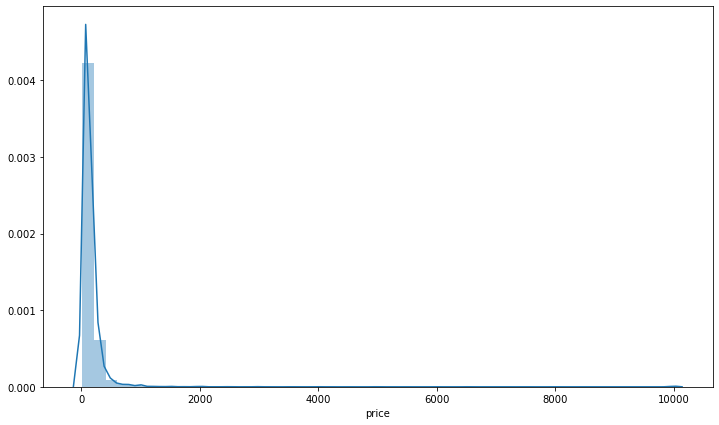

In [15]:
fig = plt.gcf()
fig.set_size_inches(12, 7)

price_fig = sns.distplot(df_geo['price'])
plt.show(price_fig)

In [16]:
#Set up epsg for neighbourhoods
nbhoods.crs = CRS('epsg:2829')
nbhoods.crs

<Projected CRS: EPSG:2829>
Name: NAD83(HARN) / New York Central
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - New York - SPCS - C
- bounds: (-77.75, 41.99, -75.04, 44.41)
Coordinate Operation:
- name: SPCS83 New York Central zone (meters)
- method: Transverse Mercator
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
nbhoods.neighbourhood_group.value_counts()

Queens           55
Bronx            50
Staten Island    48
Brooklyn         48
Manhattan        32
Name: neighbourhood_group, dtype: int64

In [18]:
df_geo_group = df_geo.groupby('neighbourhood')[['price']].median()

df_price_cloropeth = pd.merge(nbhoods, df_geo_group,
                              left_on='neighbourhood', right_index=True)

df_price_cloropeth.head()

neighbourhood neighbourhood_group  \
1       Allerton               Bronx   
2    City Island               Bronx   
44   City Island               Bronx   
4     Ozone Park              Queens   
5        Fordham               Bronx   

                                             geometry  price  
1   MULTIPOLYGON (((-73.84860 40.87167, -73.84582 ...   70.0  
2   MULTIPOLYGON (((-73.78282 40.84392, -73.78257 ...  100.0  
44  MULTIPOLYGON (((-73.78457 40.85972, -73.78471 ...  100.0  
4   MULTIPOLYGON (((-73.83754 40.69136, -73.83108 ...   80.0  
5   MULTIPOLYGON (((-73.88303 40.86663, -73.88375 ...   50.0

In [19]:
def plot_coloropeth_borough(borough_name, ax, pos):
    
    if borough_name == "all":
        ax = df_price_cloropeth.plot(ax=ax, 
                                     figsize=(15,15), 
                                     column='price', 
                                     cmap='PuBu', 
                                     scheme='quantiles',
                                     edgecolor='aqua',
                                     legend=True, 
                                     legend_kwds = pos
                                    )
    else:
        ax = df_price_cloropeth[df_price_cloropeth.neighbourhood_group \
                                == borough_name].plot(ax=ax, 
                                                      figsize=(10,10), 
                                                      column='price', 
                                                      cmap='PuBu', 
                                                      scheme='quantiles',   
                                                      edgecolor='aqua',
                                                      legend=True, 
                                                      legend_kwds = pos
                                                     )

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    return ax

In [20]:
pos = {
    "all": {'loc':'upper left'},
    "Manhattan": {'loc':'upper left'},
    "Brooklyn": {'loc':'lower right'},
    "Bronx": {'loc':'upper right'},
    "Queens": {'loc':'lower left'},
    "Staten Island": {'loc':'lower right'}
}

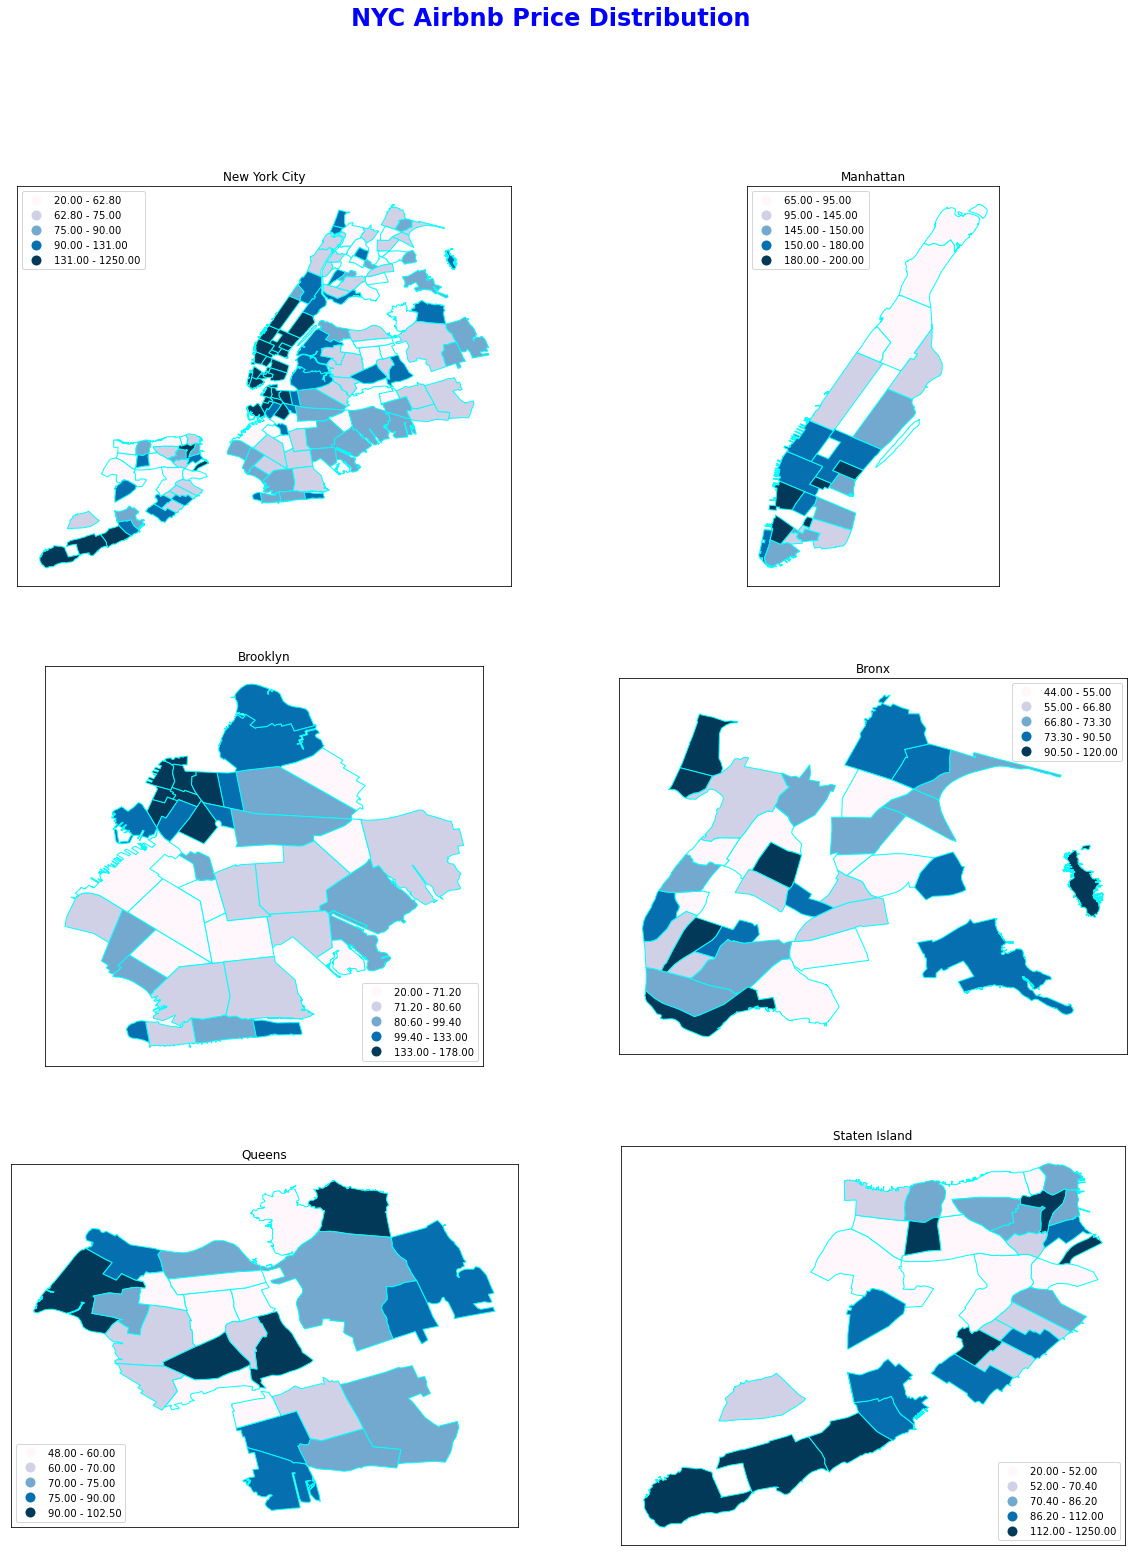

In [21]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(20, 25)
axes[0,0] = plot_coloropeth_borough("all", axes[0,0], pos["all"])
axes[0,0].set_title("New York City")
axes[0,1] = plot_coloropeth_borough("Manhattan", axes[0,1], pos["Manhattan"])
axes[0,1].set_title("Manhattan")
axes[1,0] = plot_coloropeth_borough("Brooklyn", axes[1,0], pos["Brooklyn"])
axes[1,0].set_title("Brooklyn")
axes[1,1] = plot_coloropeth_borough("Bronx", axes[1,1], pos["Bronx"])
axes[1,1].set_title("Bronx")
axes[2,0] = plot_coloropeth_borough("Queens", axes[2,0], pos["Queens"])
axes[2,0].set_title("Queens")
axes[2,1] = plot_coloropeth_borough("Staten Island", axes[2,1], pos["Staten Island"])
axes[2,1].set_title("Staten Island")

plt.suptitle("NYC Airbnb Price Distribution", 
             fontsize=24, fontweight='bold', color='Blue')

#plt.savefig('price_dist.png', dpi=300, bbox_inches='tight')

plt.show()

In [22]:
import folium
from folium.plugins import MarkerCluster

# Instantiate NYC map 
nyc_map = folium.Map(location=[df_listings['latitude'].mean(), df_listings['longitude'].mean()], zoom_start=12)

# Show superhost's location by listing id
df_superhost = df_listings[df_listings.host_is_superhost == 't']
mc = MarkerCluster()
for row in df_superhost.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude],
                              popup=row.listing_id))
                              #icon = folium.Icon(color='red', icon='info-sign')))
nyc_map.add_child(mc)
nyc_map


In [23]:
#nyc_map.save('nyc_map.html')

In [24]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49487 entries, 0 to 49529
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   listing_id           49487 non-null  int64   
 1   host_is_superhost    49487 non-null  object  
 2   latitude             49487 non-null  float64 
 3   longitude            49487 non-null  float64 
 4   neighbourhood        49487 non-null  object  
 5   neighbourhood_group  49487 non-null  object  
 6   property_type        49487 non-null  object  
 7   room_type            49487 non-null  object  
 8   accommodates         49487 non-null  int64   
 9   bathrooms            49487 non-null  float64 
 10  bedrooms             49487 non-null  float64 
 11  beds                 49487 non-null  float64 
 12  price                49487 non-null  float64 
 13  security_deposit     49487 non-null  float64 
 14  cleaning_fee         49487 non-null  float64 
 15  guests_included    

In [25]:
df_listings.isnull().sum()

listing_id             0
host_is_superhost      0
latitude               0
longitude              0
neighbourhood          0
neighbourhood_group    0
property_type          0
room_type              0
accommodates           0
bathrooms              0
bedrooms               0
beds                   0
price                  0
security_deposit       0
cleaning_fee           0
guests_included        0
availability_365       0
number_of_reviews      0
geometry               0
dtype: int64

In [26]:
# Drop unnecessary features 
df = df_listings.drop(['geometry', 'listing_id', 'host_is_superhost','latitude', 'longitude'], axis=1)
#df.to_csv('sample.csv', encoding='utf-8', index=False)
df.shape

(49487, 14)

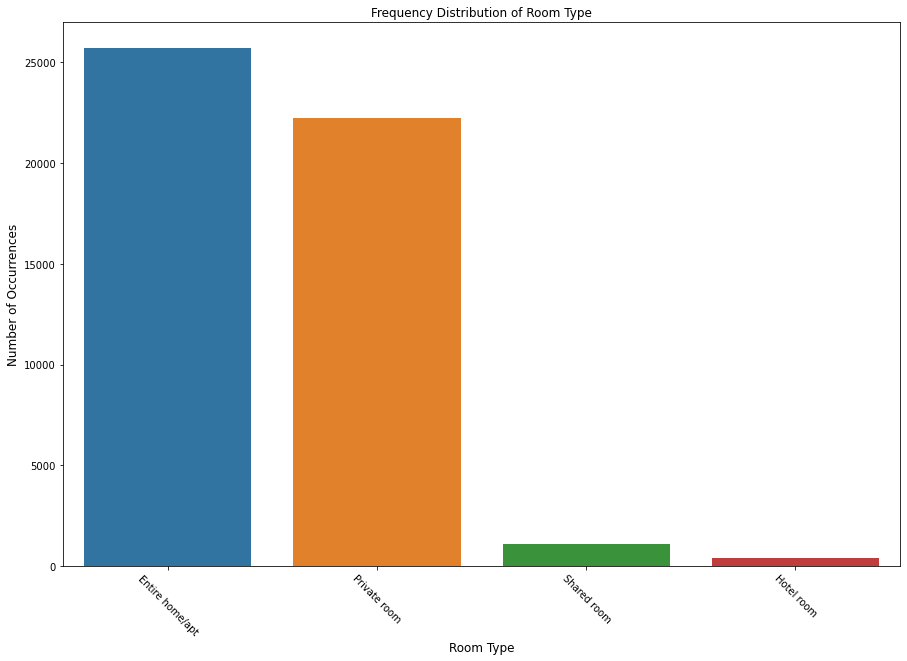

In [27]:
# Show room type distribution
room_type_count = df['room_type'].value_counts()
plt.figure(figsize=(15,10))

sns.barplot(room_type_count.index, room_type_count.values)
plt.title('Frequency Distribution of Room Type')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Room Type', fontsize=12)
plt.xticks(rotation=-45)
plt.savefig('room_type_dist.png', dpi=300)
plt.show()

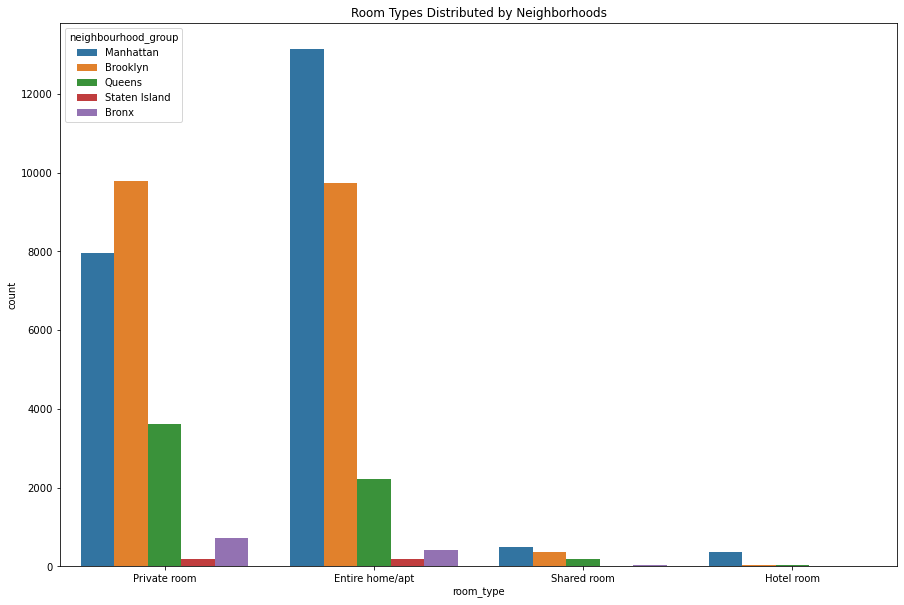

In [28]:
# Room type across neighborhoods
plt.figure(figsize=(15,10))
sns.countplot(x = 'room_type', hue = "neighbourhood_group", data = df)
plt.title("Room Types Distributed by Neighborhoods")
#plt.savefig('room_type_nbhood.png', dpi=300)
plt.show()

In [29]:
# Correlation between features and the target 'price'
df.corr().style.background_gradient(cmap='coolwarm')

In [30]:
# Drop missing values
dfs=df.dropna(subset=['price'], axis=0)
df = df.dropna(how='all', axis=1)

# List of column names of categorical variables
cat_df = df.select_dtypes(include=['object'])
cat_cols_list = cat_df.columns
#cat_cols_list

df_new = create_dummy_df(df, cat_cols_list, dummy_na=False)
df_new.shape

(49487, 251)